In [1]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py

--2019-07-05 16:41:45--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374 [text/plain]
Saving to: ‘metrics.py.1’

100%[======================================>] 374         --.-K/s   in 0s      

2019-07-05 16:41:45 (92.5 MB/s) - ‘metrics.py.1’ saved [374/374]



In [2]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py

--2019-07-05 16:41:45--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/user_test_submission.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6143 (6.0K) [text/plain]
Saving to: ‘user_test_submission.py.1’

100%[======================================>] 6,143       --.-K/s   in 0s      

2019-07-05 16:41:46 (113 MB/s) - ‘user_test_submission.py.1’ saved [6143/6143]



In [3]:
! wget https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv

--2019-07-05 16:41:46--  https://raw.githubusercontent.com/yandexdataschool/mlhep2019/master/notebooks/day-5/tracking/public_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18420554 (18M) [text/plain]
Saving to: ‘public_train.csv.1’

100%[======================================>] 18,420,554  93.6MB/s   in 0.2s   

2019-07-05 16:41:47 (93.6 MB/s) - ‘public_train.csv.1’ saved [18420554/18420554]



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

import user_test_submission as submission

In [6]:
import numpy as np
import math
from metrics import predictor
from sklearn.base import BaseEstimator

# Track Pattern Recognition using Linear Approximation of a Track
Original competition: https://ramp.studio/problems/HEP_tracking

## Introduction

Track pattern recognition is an early step of the reconstruction of data coming from a particle detector. It recognizes tracks among the subdetectors hits. Reconstructed track parameters allow to estimate the particle deviation in a magnetic field, and thus reconstruct its charge and momentum. This information is used for the reconstruction of the decay vertex, to identify the mother particle and for further particle identification.

There is wide variety of the track pattern recognition methods. They differ in how they process the hits, what kind of tracks they are able to recognize and which requirements these tracks should satisfy. Therefore, specifics of an experiment and the detector geometry affect the tracking performance and track pattern recognition methods should be adapted to it accordingly.

In this notebook a track pattern recognition for a 2D detector with circular geometry and uniform magnetic field is considered. The detector schema with hits and tracks of an event is shown in the figure below. The challenge is to recognize tracks of an event with the highest efficiecny. It supposed that one hit can belong to only one track. 

<img src="pic/detector.png" /> <br>




## Quick Glossary

We use the following vocabulary in the context of practice session. It may be slightly different from the general high-energy physics context. Some terms are not used in the workbook, but kept here in case they are used in the discussions.

* **event**: a recorded (or simulated) collision in which many particles are present, the basic unit of particle physics data
* **pixel**: the smallest detector unit
* **hit**: a pixel through which a particle has passed and left signal in a given event
* **cluster**: a set of hits, belonging (or predicted to be belonging) to the trajectory of a single particle
* **reconstruct**: same thing as predict, but may also refer to further derived quantities
* **track**: a reconstructed particle, that is, a cluster but also including additional derived information, such as the overall curvature and angle
* **vertex**: the point close to the center of the detector, from which the particles have originated
* **impact parameter**: the shortest distance between a track and the origin
* **(momentum/angle/etc) resolution** : width of the normal distribution of the difference between a predicted quantity and the true value of that quantity

## Objectives

The main objective of the challenge is the optimal matching of the hits in an event. The positions of the hits in the detector are provided as input data, and the user is expected to implement a clustering scheme (trained on data if needed), so that every hit is assigned to a cluster id.

The value of the cluster id itself is not relevant for the task, what is relevant is which hits are clustered together, and whether this clustering corresponds well to the input particles. The score function that describes this is included in the notebook, and details will be mentioned there.

## Application

The user is expected to implement the class `clusterer.py`, which contains the `__init__`, `fit`, and `predict_single_event` functions.

* **`__init__`** is where parameters should be set.
* **`fit`** is the training function (not to be confused with track-fitting), where the algorithm has access to the ground-truth. This function is to be run once on an input array that contains a set of training events. The user is able to implement any event-level or particle-level segmentation of the input array in order to set up the training in any desired way.
* **`predict_single_event`** is the function to reconstruct the hit clusters (tracks), returning an array of predicted (reconstructed) ids associated to each hit in the input array. This function takes only the hits from a single event as input, with the event_id dropped, and the RAMP machinery takes care of running this function on each event.

The **task**  is to implement this class in a way that the predict_single_event function returns a numpy array of assigned cluster ids. At any level of this task, machine-learning techniques can be employed for sub-tasks defined by the user.

## Detector

Image from the Atlas experiment:

<img src="pic/atlas2009.png" /> <br>

The data provided to the user is a list of hit positions from a simple toy detector model that mimics the Atlas detector design (which is generic enough for recent silicon-based tracking detectors). The detector has an onion-like geometry with 9 layers surrounding the origin with polar distances of $R = [39,85,155,213,271,405,562,762,1000]$ cm. These layers have a very small thicknesses compared to the distances, therefore the thickness can be neglected.

Each layer is segmented in azimuth with high granularity. There are ($2\pi$R/pitch)+1 pixels in every layer, where pitch is 0.025 cm for layers 0-4 and 0.05 cm for layers 5-9.

Every "pixel" corresponds to the smallest detector unit defined by `layer` and `iphi` (azimuthal index).

## Simulation

The task uses a toy model for particle generation and simulation, in which a Poisson distribution is sampled to determine the number of particles in each event, with an average of 10 particles per event.

The particles are sampled uniformly in azimuth and momentum with bounds on the momentum. Each particle originates from a vertex that is also randomly sampled from a narrow normal distribution around the origin. The proper dimensions of the momentum and position and determination of these values for the tracks are beyond the scope of the challenge.

The particles generated this way are simulated in a uniform magnetic field. The detector material is considered to cause multiple-scattering, and this is implemented as a random rotation of the particle momentum at every detector position, sampled from a narrow normal distribution that roughly corresponds to the material of the Atlas tracker.

In addition, some hit inefficiency is simulated by a random drop of some hits (with 3% probability), and a particle stopping probability of 1% is applied at each layer to simulate effects of hadronic interactions. Keeping these in mind, the algorithms might be desired to be able to handle cases when the particle doesn't have a hit on every layer.

Since the detector has a very high granularity in azimuth, the cases where two particles pass through a single pixel are neglected (less than 0.2% probability).



## About this notebook

This notebook demonstrate how linear approximation of a track can be used for track pattern recognition. The notebook describes input data, the track pattern recognition method and qualyti metrics, and shows how to use them.

In [ ]:
#!sudo pip install sklearn==0.18.1

# Input data

In [7]:
data = pandas.read_csv('public_train.csv', index_col=False)

data.head()

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583


## Exploratory data analysis

### Data Preparation

In [8]:
X = data.drop(['cluster_id'], axis=1).values
y = data[['event_id', 'cluster_id']].values

### Visualize the hits in a single event

In [9]:
# Get event ids
event_ids = X[:, 0]

# Estimate unique event ids
unique_event_ids = np.unique(event_ids)

# Choose an event
i_event = unique_event_ids[0]

X_event = X[event_ids == i_event]
y_event = y[event_ids == i_event]

In [10]:
def plot_event(X, y=None, is_plot=True):
    
    cmap = ['k', 'b', 'y', 'g', 'r', 'k']
    R=[39, 85, 155, 213, 271, 405, 562, 762, 1000]
    
    hit_x = X[:, 3]
    hit_y = X[:, 4]
    
    plt.figure(figsize=(6, 6))
    if y is None:
        plt.scatter(hit_x, hit_y)
        
    if y is not None:
        for i_track in np.unique(y):
            track_mask = y == i_track
            track_x = hit_x[track_mask]
            track_y = hit_y[track_mask]
            track_r = np.sqrt(track_x**2 + track_y**2)
            sorted_ids = np.argsort(track_r)
            if is_plot:
                plt.plot(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
            plt.scatter(track_x[sorted_ids], track_y[sorted_ids], color=cmap[int(i_track) % len(cmap)])
        
    for ar in R:
        circle=plt.Circle((0,0), ar, color='0.5', fill=False)
        plt.gcf().gca().add_artist(circle)
    
    plt.xlim(-1100, 1100)
    plt.ylim(-1100, 1100)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel('X', size=12)
    plt.ylabel('Y', size=12)
    plt.show()

You have this:


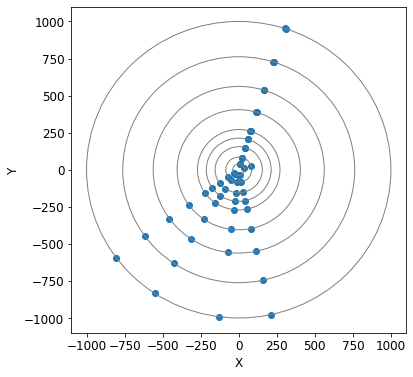

You need to get this:


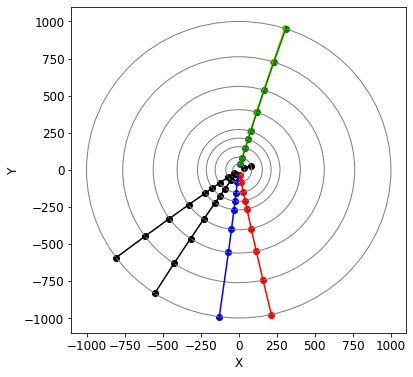

In [11]:
print("You have this:")
plot_event(X_event, None)

print("You need to get this:")
plot_event(X_event, y_event[:, 1])

## Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split


event_ids = numpy.unique(data['event_id'].values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=1000, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train)], y[data['event_id'].isin(event_ids_train)]
X_test, y_test   = X[data['event_id'].isin(event_ids_test)],  y[data['event_id'].isin(event_ids_test)]

# Track Pattern Recognition

## Clustering based approach

This method is based on the clustering methods. 

In [13]:
class Clusterer(object):

    def __init__(self, cluster=None):

        self.cluster = cluster

    def get_polar(self, x, y):

        x = numpy.array(x)
        y = numpy.array(y)

        phi = numpy.arctan2(y, x)
        r = numpy.sqrt(x**2 + y**2)

        return r, phi

    
    def fit(self, X, y):
        pass

    
    def predict_single_event(self, X):

        x, y = X[:, 3], X[:, 4]
        r, phi = self.get_polar(x, y)

        self.cluster.fit(phi.reshape(-1, 1))
        labels = self.cluster.labels_
        
        return labels

In [34]:
from sklearn.cluster import KMeans

ctr = Clusterer(cluster=KMeans(n_clusters=5, n_init=1))

### Test on single event

In [35]:
y_event_pred = ctr.predict_single_event(X_event)
y_event_pred

array([ 0,  1,  1,  2,  0,  2,  2,  2,  2,  3,  2,  1,  4,  2,  4,  3,  2,
        2, -1,  0,  2,  4,  2,  3,  2,  0,  4,  4,  1,  4,  1,  4,  2,  3,
        4,  0,  3,  0,  3,  2,  3,  0,  1,  2,  2,  1,  0,  0, -1,  3,  1,
        2,  2,  3,  4])

Recognized tracks:


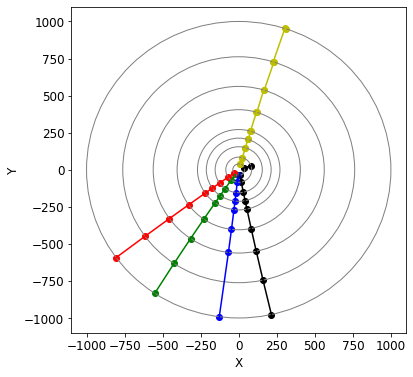

In [36]:
print("Recognized tracks:")
plot_event(X_event, y_event_pred)

### Test on several events

In [37]:
# %%time
from metrics import predictor
y_pred_test = predictor(ctr, X_test, y_test)

In [38]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8407


# Task 1

Try to improve the score of track pattern recognition using clustering algorithms.

In [40]:
from sklearn.cluster import DBSCAN

ctr = Clusterer(cluster=DBSCAN(eps=0.05, min_samples=1))
y_pred_test = predictor(ctr, X_test, y_test)

score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8637


# RNN based tracks pattern recognition

Original article: https://www.epj-conferences.org/articles/epjconf/pdf/2017/19/epjconf_ctdw2017_00003.pdf

We will use a basic LSTM model architecture used to classify hits for one track. The LSTM and a fully-connected layer with a softmax activation read the pixel arrays and predict which pixels belong to the target track.

<img src="pic/model.png" width="600"/> <br>

## Data preparation

In [41]:
num_phi_bin = 100

In [42]:
# Data preprocessing functions

class det_geo():
    layer_r     = np.array([39,    85,    155,   213,   271,   405,  562,  762,  1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0.05, 0.05])
    num_layers = layer_r.shape[0]
    max_phi = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)

    
def rescale_phi(phi, nbin, layer):
    return (phi * float(nbin) / det_geo.max_phi[layer.astype(np.int)]).astype(np.int)


def event_hits_transform(X, y=None, num_phi_bin=100):
    
    evids, layers, phis = X[:,0].astype(np.int), X[:,1].astype(np.int), X[:,2].astype(np.int)
    phis = rescale_phi(phis, num_phi_bin, layers)
    
    # Count the number of first-layer hits, which will be my seeds
    seed_idx = np.where(layers == 0)[0]
    num_seeds = seed_idx.size

    # Training input will contain the seed hit followed by the rest of the event
    train_input = np.zeros((num_seeds, det_geo.num_layers, num_phi_bin))
    # Training targets will be images of the individual signal tracks
    train_target = np.zeros_like(train_input)

    # Loop over training samples to prepare (seeds)
    for i_sample in range(num_seeds):
        
        i_hit = seed_idx[i_sample]

        # Fill the input first layer with just the seed hit
        train_input[i_sample, 0, phis[i_hit]] = 1
        # Fill the other layers with all remaining event hits
        train_input[i_sample, layers[layers > 0], phis[layers > 0]] = 1

        # Fill target with hits from this track
        if y is not None:
            track_ids = y[:, 1]
            seed_track_id = y[i_hit, 1]
            train_target[i_sample, layers[track_ids == seed_track_id], phis[track_ids == seed_track_id]] = 1
        
    return train_input, train_target

In [43]:
# Data visualization function

def plot_event_polar(X):
    
    plt.figure(figsize=(6, 6))
    
    plt.pcolor(X.T)
    
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.xlabel('Layer bins', size=12)
    plt.ylabel('Phi bins', size=12)
    
    plt.show()

### Preprocess one event

In [44]:
# Preprocessing
X_event_polar, y_event_polar = event_hits_transform(X_event, y_event, num_phi_bin)

In [45]:
# Display shapes
X_event_polar.shape, y_event_polar.shape

((7, 9, 100), (7, 9, 100))

Original event hits:


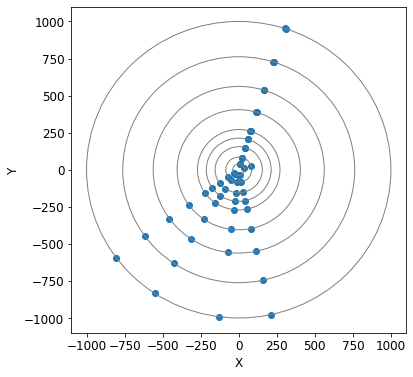

RNN inputs for one track of the event:


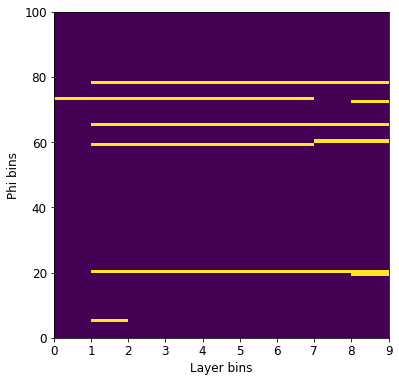

RNN outputs for the track:


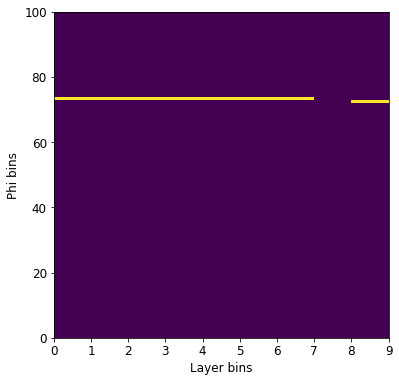

In [46]:
i_train = 0

print("Original event hits:")
plot_event(X_event, None)

print("RNN inputs for one track of the event:")
plot_event_polar(X_event_polar[i_train])

print("RNN outputs for the track:")
plot_event_polar(y_event_polar[i_train])

### Preprocess all training events

In [47]:
# Preprocessing
train_input = []
train_target = []

event_ids = X_train[:, 0]
for i_event in np.unique(event_ids):
    
    # Take one event
    X_ev = X_train[event_ids == i_event]
    y_ev = y_train[event_ids == i_event]

    # Preprocess this event
    train_input_ev, train_target_ev = event_hits_transform(X_ev, y_ev, num_phi_bin)
    
    # Store the preprocessed events
    train_input.append(train_input_ev)
    train_target.append(train_target_ev)

X_train_polar = np.concatenate(tuple(train_input))
y_train_polar = np.concatenate(tuple(train_target))

In [48]:
# Display shapes
X_train_polar.shape, y_train_polar.shape

((38565, 9, 100), (38565, 9, 100))

## Define RNN model

In [49]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook

# Estimate device to train a model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Define a model
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTM(100, 50, batch_first=True)
        self.dense1 = nn.Linear(50, 100)
        self.softmax = nn.Softmax()
 
    def forward(self, x):
        
        hid_sequence, (c_last, h_last) = self.lstm1(x)
        hid_sequence = self.dense1(hid_sequence)
        logits = self.softmax(hid_sequence)
        return logits

cuda


## Fit the RNN model

In [52]:
class MyClassifier(object):
    
    def __init__(self, model, n_epochs=10, batch_size=64):
        """
        Class to fit a pytorch model and to use it to make predictions.
        
        Parameters
        ----------
        model: object
            PyTorch model.
        n_epochs: int
            Number of epochs to fit the model.
        batch_size: int
            The batch size used for the model fitting.
        """
        
        self.model = model
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        
    
    def fit(self, X, y):
        """
        Fit the PyTorch model.
        
        Parameters
        ----------
        X: numpy.array
            The model imput data.
        y: numpy.array
            Targets to predict.
        """
        
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        y_tensor = torch.as_tensor(y, dtype=torch.float32, device=device)
        
        # Create dataset for trainig procedure
        train_data = TensorDataset(X_tensor, y_tensor)
        
        # Estimate optimizer
        opt = torch.optim.Adam(self.model.parameters())
        
        # Enable droout
        self.model.train(True)
        
        # Start the model fit
        for epoch_i in range(self.n_epochs):
            loss_history = []
            for x_batch, y_batch in DataLoader(train_data, batch_size=self.batch_size, shuffle=True):
                # make prediction on a batch
                logits = self.model(x_batch)
                # calculate loss
                loss = -(torch.log(logits) * y_batch).sum(-1).mean()
                # set gradients to zero
                opt.zero_grad()
                # backpropagate gradients
                loss.backward()
                # update the model weights
                opt.step()
                loss_history.append(loss.item())
            print("epoch: %i, mean loss: %.5f" % (epoch_i, np.mean(loss_history)))
    
    def predict(self, X):
        """
        Make predictions for the model.
        
        Parameters
        ----------
        X: numpy.array
            The model imput data.
        """
        
        # Disable droout
        self.model.train(False)
        
        # Convert X and y into torch tensors
        X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
        # Make predictions for X 
        y_pred = model(X_tensor)
        
        return y_pred.cpu().detach().numpy()

In [53]:
# Create a pytorch model
model=Model().to(device=device)

# Fit the model
clf = MyClassifier(model=model, n_epochs=50, batch_size=64)
clf.fit(X_train_polar, y_train_polar)

epoch: 0, mean loss: 3.17979
epoch: 1, mean loss: 1.99565
epoch: 2, mean loss: 1.52416
epoch: 3, mean loss: 1.34413
epoch: 4, mean loss: 1.23916
epoch: 5, mean loss: 1.15056
epoch: 6, mean loss: 1.08147
epoch: 7, mean loss: 1.02594
epoch: 8, mean loss: 0.97072
epoch: 9, mean loss: 0.92176
epoch: 10, mean loss: 0.87789
epoch: 11, mean loss: 0.83428
epoch: 12, mean loss: 0.79314
epoch: 13, mean loss: 0.75883
epoch: 14, mean loss: 0.72926
epoch: 15, mean loss: 0.70590
epoch: 16, mean loss: 0.68094
epoch: 17, mean loss: 0.66536
epoch: 18, mean loss: 0.64454
epoch: 19, mean loss: 0.62767
epoch: 20, mean loss: 0.61607
epoch: 21, mean loss: 0.60186
epoch: 22, mean loss: 0.59416
epoch: 23, mean loss: 0.58095
epoch: 24, mean loss: 0.58029
epoch: 25, mean loss: 0.56651
epoch: 26, mean loss: 0.55812
epoch: 27, mean loss: 0.55148
epoch: 28, mean loss: 0.54864
epoch: 29, mean loss: 0.54358
epoch: 30, mean loss: 0.53993
epoch: 31, mean loss: 0.53223
epoch: 32, mean loss: 0.52476
epoch: 33, mean loss

In [54]:
# Make predictions for one event
y_event_polar_pred = clf.predict(X_event_polar)

RNN output for the track:


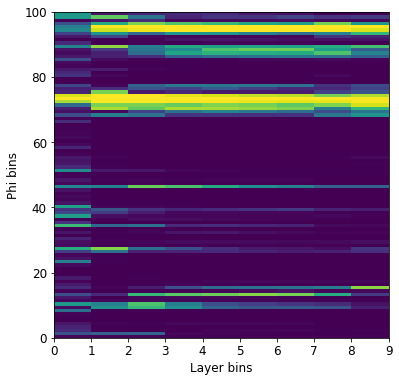

True output for the track:


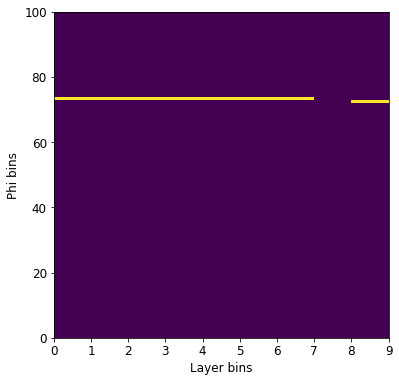

In [55]:
print("RNN output for the track:")
plot_event_polar(y_event_polar_pred[i_train])

print("True output for the track:")
plot_event_polar(y_event_polar[i_train])

## Test track pattern recognition algorithm

In [56]:
class Clusterer(object):

    def __init__(self, classifier=None):

        self.classifier = classifier
    
    def fit(self, X, y):
        pass

    
    def predict_single_event(self, X):

        trkid = np.zeros(X.shape[0])
        for i in range(trkid.shape[0]):
            
            lays, phis = X[:,1].astype(np.int), X[:,2].astype(np.int)
            phis = rescale_phi(phis, num_phi_bin, lays)
            lay, phi = lays[i], phis[i]
            
            # Preprocess the event
            X_polar, _ = event_hits_transform(X, None, num_phi_bin)
            # Get predictions for the event
            y_polar_pred = clf.predict(X_polar)

            # Get the list of track scores
            scores = y_polar_pred[:, lays[i], phis[i]]

            # Select the best score
            best = np.argmax(scores)
            trkid[i] = best
            
        return trkid

In [57]:
ctr = Clusterer(classifier=clf)

y_event_pred = ctr.predict_single_event(X_event)
y_event_pred

array([1., 0., 0., 3., 1., 3., 3., 3., 3., 5., 3., 0., 2., 3., 2., 5., 3.,
       3., 4., 1., 3., 2., 3., 5., 3., 1., 2., 2., 0., 2., 0., 2., 3., 5.,
       2., 1., 5., 1., 5., 3., 5., 1., 0., 3., 3., 0., 1., 1., 4., 5., 0.,
       3., 3., 5., 2.])

Recognized tracks:


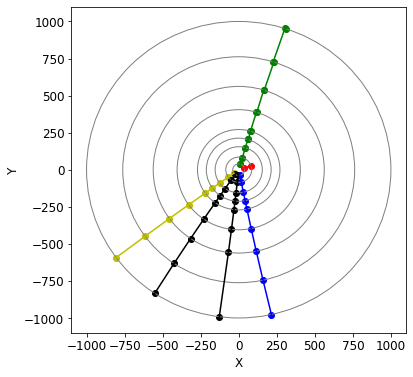

In [58]:
print("Recognized tracks:")
plot_event(X_event, y_event_pred, is_plot=True)

In [59]:
# %%time
from metrics import predictor
y_pred_test = predictor(ctr, X_test, y_test)

In [60]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.8786


# Task 2

Create a deep model with the following layers:
* Input layer
* LSTM with 200 hidden neurons
* 30% dropout
* LSTM with 150 hidden neurons
* 20% dropout
* Output dense layer with 100 neurons and Softmax activation.

In [ ]:
# Define a model
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Your code is here ###
 
    def forward(self, x):
        
        ### Your code is here ###
        
        return logits

In [ ]:
# Create a pytorch model
### Your code is here ###

# Fit the model
### Your code is here ###

In [ ]:
%%time
# Calculate the quality score
### Your code is here ###

# Task 3 (for the Jedi)

Try to improve the score. Fill free to change anything you want. 

In [ ]:
### Your code is here ###